# T02: Ultimate background removal 2000
Aluno: Gabriel Finger Conte

Problema: Criar uma função para remoção automática de fundo de imagens. A função deve ser chamada para as imagens exemplo abaixo e a máscara resultante deve ser mostrada.

In [76]:
# Importando as bibliotecas necessárias
import cv2
import numpy as np
import matplotlib.pyplot as plt

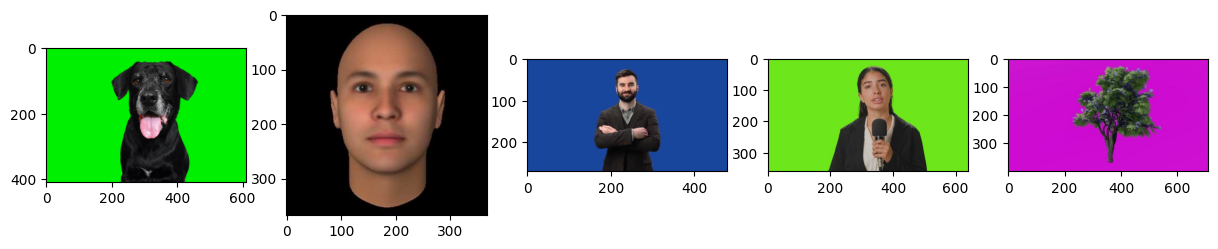

In [77]:
# Importando as imagens
IMAGE_NAMES = ['black-dog.png', 'black.jpg', 'blue.png', 'green_1.jpg', 'purple.jpg']
imgs = []

# Importa as imagens salvando-as em um vetor
for name in IMAGE_NAMES:
    # Lê a imagem
    new_img = cv2.imread(name)
    # Salva a imagem convertida já para RGB
    imgs.append(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))    

# Exibe as imagens para verificar a importação
plt.figure(figsize=(15,5))
for idx,img in enumerate(imgs,1):
    plt.subplot(1,5,idx)
    plt.imshow(img)

plt.show()

## Função desenvolvida para imagens no formato RGB (retornando RGBA)

In [78]:
def rgb_bg_removal2000_8b(src_img: np.matrix, threshold: int):
    """
    Remove o fundo de uma imagem, assumindo que o fundo é monocromático (de cor predominante) e torna-o transparente, 
    gerando uma máscara (canal alpha) e a imagem resultante sem o fundo.

    Args:
        src_img (np.matrix(dtype=np.uint8)): Imagem de entrada em formato RGB (3 canais) da qual o fundo será removido.
        threshold (int): Valor de tolerância para ajustar o intervalo de cor considerado como fundo. 
            Um valor maior aumenta a gama de cores que serão tratadas como fundo.

    Returns:
        alpha_mask(np.matrix(dtype=np.uint8)): Máscara binária indicando as áreas do fundo (0) e das partes visíveis (255).
        bgless_img(np.matrix(dtype=np.uint8)): Imagem com o fundo removido e substituído por transparência (formato RGBA, com 4 canais).
    """

    # Separando os canais da imagem
    src_chanels = np.array(cv2.split(src_img),dtype=np.uint8)

    # Canais da máscara a ser gerada
    mask_chanels = np.zeros(src_chanels.shape,dtype=np.uint8)
    
    # Parâmetros do cálculo do histograma
    hist_chanels=[0]
    hist_mask=None
    hist_size=[256]
    hist_ranges=[0,256]

    for idx,canal in enumerate(src_chanels):
        # Calcula o histograma para obter a distribuição dos valores dos pixels no canal
        hist = cv2.calcHist([canal],hist_chanels,hist_mask,hist_size,hist_ranges)
        # Pega o índice do histograma com o maior valor, sendo esse o valor do canal no background
        bg_color_value = hist.argmax()
        # Define os limiares de valor a serem considerados a partir do threshhold
        low = bg_color_value - threshold
        high = bg_color_value + threshold
        # Gera a máscara do canal, a partir de uma cópia do canal
        aux_mask = canal.copy()
        # Verifica se o valor é zero (caso especial)
        if bg_color_value == 0:
            # Todos os valores maiores que o limite superior é maximizado
            aux_mask[aux_mask > high] = 255
            # O restante é zerado
            aux_mask[aux_mask < 255] = 0
            # Selecionamos assim tudo que não é o background 
            mask_chanels[idx] = aux_mask
            
        else:
            # Zera tudo fora dos limites definidos
            aux_mask[aux_mask <= low] = 0
            aux_mask[aux_mask >= high] = 0
            # O conteúdo dentro é maximizado
            aux_mask[aux_mask > low] = 255
            # Selecionamos o background, assim invertemos a máscara para ignorar o background
            mask_chanels[idx] = cv2.bitwise_not(aux_mask)
    
    # Juntamos os canais para gerar a máscara e convertemos para a escala de cinza para uma máscara binária
    rgb_mask = cv2.merge([mask_chanels[0],mask_chanels[1],mask_chanels[2]])
    alpha_mask = np.matrix(cv2.cvtColor(rgb_mask,cv2.COLOR_RGB2GRAY))
    # Ajustamos a máscara para o formato binário
    alpha_mask[alpha_mask > 0] = 255
    # Removemos o fundo da imagem segundo a máscara gerada
    bgless_img = cv2.merge([src_img[:,:,0],src_img[:,:,1],src_img[:,:,2],alpha_mask])
    
    # Retornamos a máscara e a imagem sem o fundo
    return alpha_mask,bgless_img

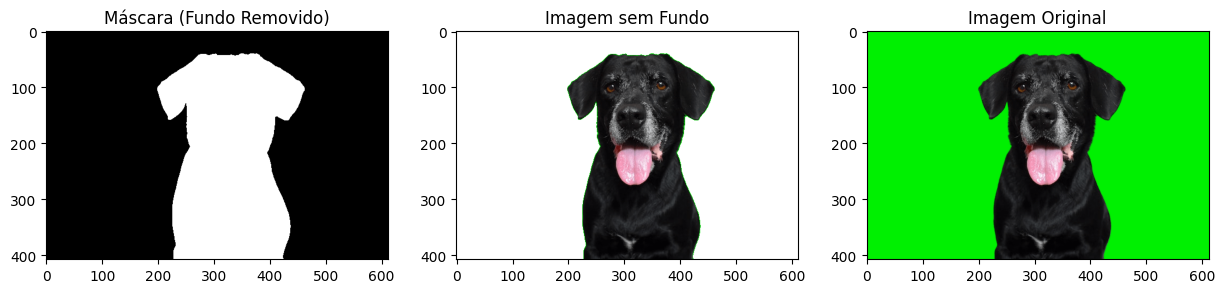

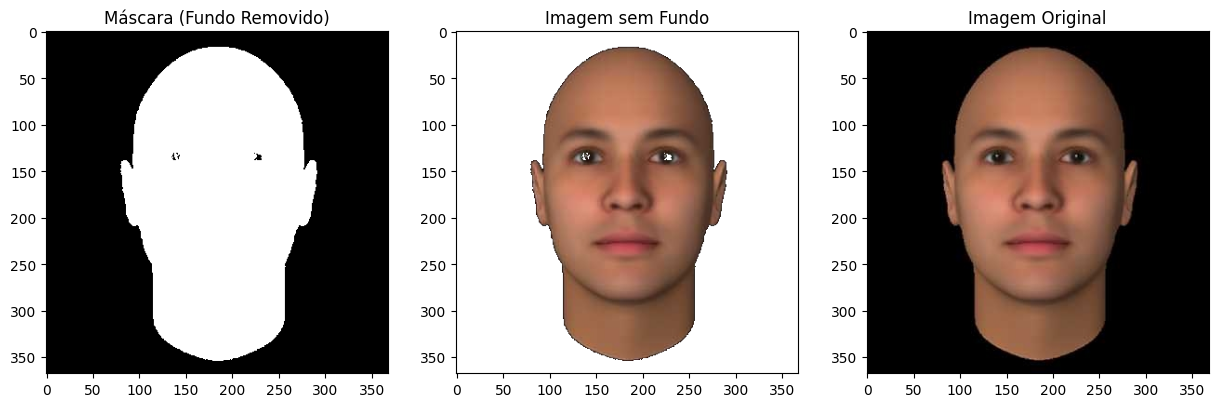

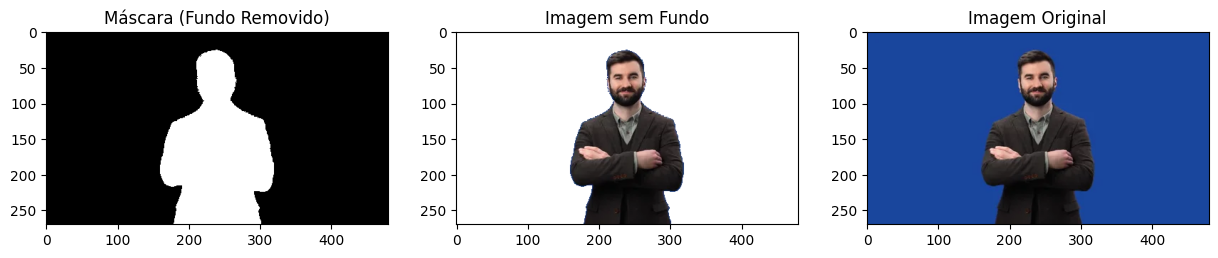

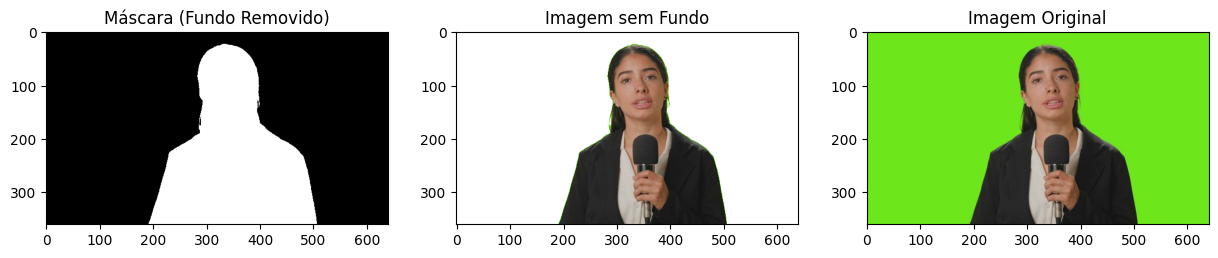

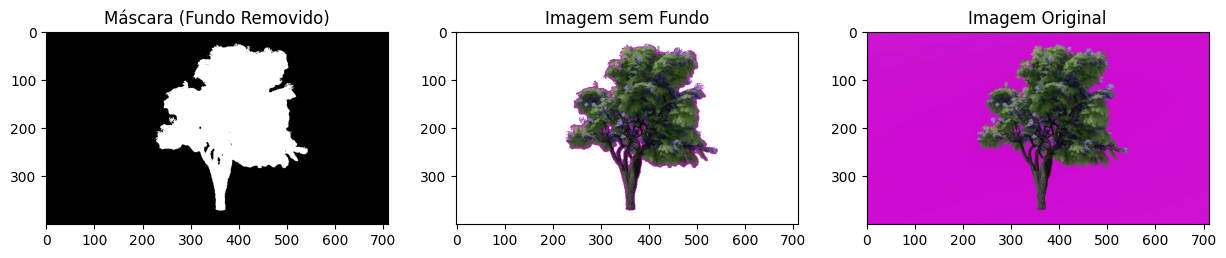

In [79]:
# Aplica a função desenvolvida para cada imagem
for img in imgs:
    # Obtém a máscara e a imagem sem o fundo
    mask, bgless_img = rgb_bg_removal2000_8b(img, 30)
    
    plt.figure(figsize=(15,5))
    
    # Primeira subplot: exibe a máscara em escala de cinza
    plt.subplot(1, 3, 1)
    plt.imshow(mask, cmap="gray")
    plt.title("Máscara (Fundo Removido)")
    
    # Segunda subplot: exibe a imagem com fundo removido
    plt.subplot(1, 3, 2)
    plt.imshow(bgless_img)
    plt.title("Imagem sem Fundo")
    
    # Terceira subplot: exibe a imagem original
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.title("Imagem Original")
    
    plt.show()


## Função para imagens HLS (retornando RGBA)

In [80]:
def hls_bg_removal2000_8b(src_img,hue_tol=10):
    """
    Remove o fundo de uma imagem no espaço de cor HLS, assumindo que o fundo é monocromático (predominante), 
    e o torna transparente. A função adiciona um canal alfa para controlar a transparência nas áreas correspondentes ao fundo.

    Args:
        src_img (np.ndarray): Imagem de entrada no formato HLS (Hue, Luminância, Saturação) com 3 canais.
        hue_tol (int, optional): Tolerância para o intervalo do tom (Hue) considerado como fundo. Default é 10.
        lum_tol (tuple(int, int), optional): Intervalo da luminância (Luminance) para definir o fundo. Default é (50, 255).
        sat_tol (tuple(int, int), optional): Intervalo da saturação (Saturation) para definir o fundo. Default é (50, 255).

    Returns:
        alpha_mask (np.ndarray): Máscara binária indicando as áreas do fundo (0) e das partes visíveis (255).
        bgless_img (np.ndarray): Imagem com o fundo removido e substituído por transparência (formato RGBA, com 4 canais).
    """
    
    # Pega o canal hue para determinar a cor do background
    hue,lightness,saturation = cv2.split(src_img)
    
    # Parâmetros do cálculo do histograma
    hist_chanels=[0]
    hist_mask=None
    hist_size=[256]
    hist_ranges=[0,256]
    
    # Calcula o histograma para obter a distribuição dos valores dos pixels no canal
    hist = cv2.calcHist([hue],hist_chanels,hist_mask,hist_size,hist_ranges)
    # Pega o índice do histograma com o maior valor, sendo esse o valor do canal no background
    bg_hue_value = hist.argmax()
    
    # Calcula o histograma para obter a distribuição dos valores dos pixels no canal
    hist = cv2.calcHist([lightness],hist_chanels,hist_mask,hist_size,hist_ranges)
    # Pega o índice do histograma com o maior valor, sendo esse o valor do canal no background
    bg_lightness_value = hist.argmax()
    
    # Calcula o histograma para obter a distribuição dos valores dos pixels no canal
    hist = cv2.calcHist([saturation],hist_chanels,hist_mask,hist_size,hist_ranges)
    # Pega o índice do histograma com o maior valor, sendo esse o valor do canal no background
    bg_saturation_value = hist.argmax()
    
    # Parâmetros para definição dos limites
    lum_tol=(50, 255)
    sat_tol=(50, 255)
    # Se o fundo for preto, altera os parâmetros dos limimtes devido a natureza da configuração HLS
    if(bg_lightness_value < 50 and bg_saturation_value < 50):
        lum_tol=(0, 50)
        sat_tol=(0, 50)
    
    # Define os limites
    low = np.array([max(0,bg_hue_value - hue_tol),lum_tol[0],sat_tol[0]])
    high = np.array([min(180,bg_hue_value + hue_tol),lum_tol[1],sat_tol[1]])
    
    # Criar uma máscara para o intervalo de cor especificado
    mask = cv2.inRange(src_img, low, high)
    
    # Inverte a mascara para pegar o que não for o fundo
    alpha_mask = cv2.bitwise_not(mask)
    
    # Converte os canais da imagem para RGB
    rgb_src_img = cv2.cvtColor(src_img,cv2.COLOR_HLS2RGB)
    
    # Removemos o fundo da imagem segundo a máscara gerada (Canal alpha)
    bgless_img = cv2.merge([rgb_src_img[:,:,0],rgb_src_img[:,:,1],rgb_src_img[:,:,2],alpha_mask])
    
    # Retornamos a máscara e a imagem sem o fundo
    return alpha_mask,bgless_img

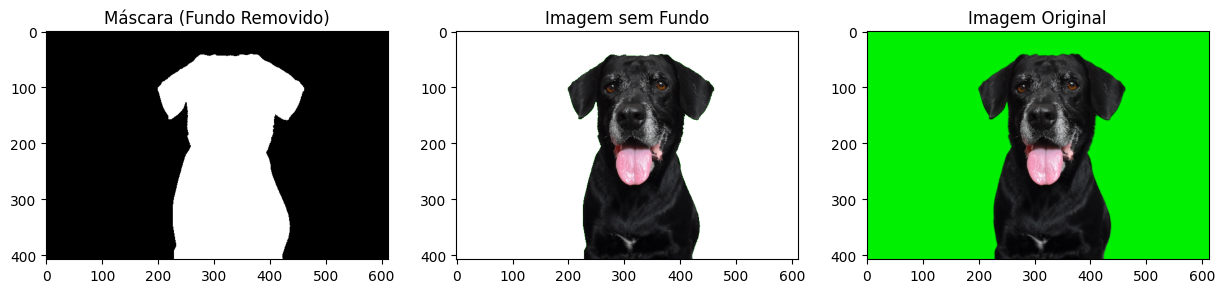

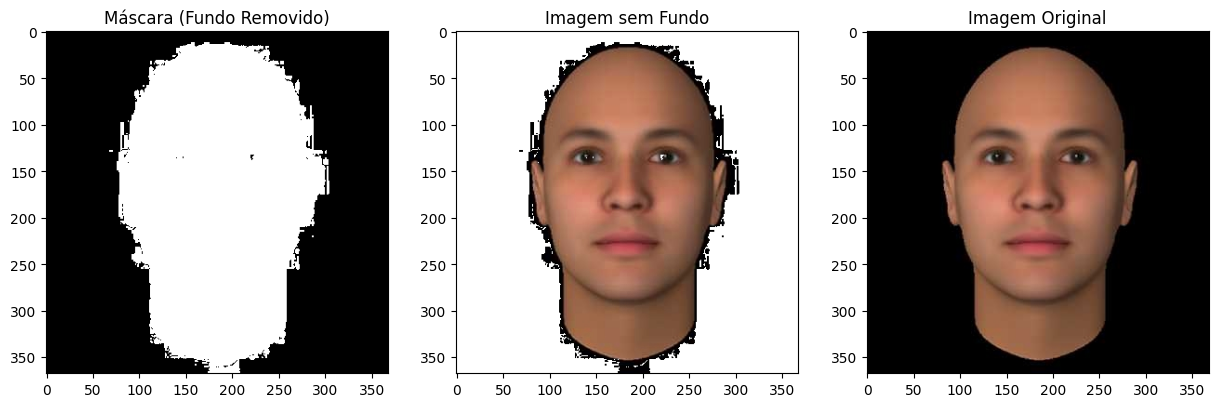

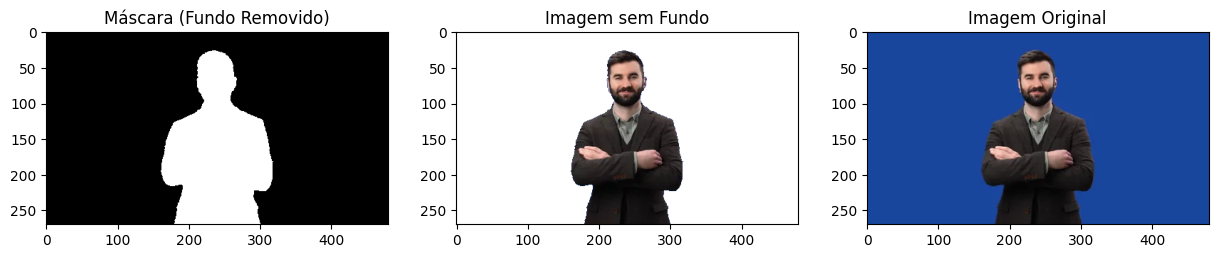

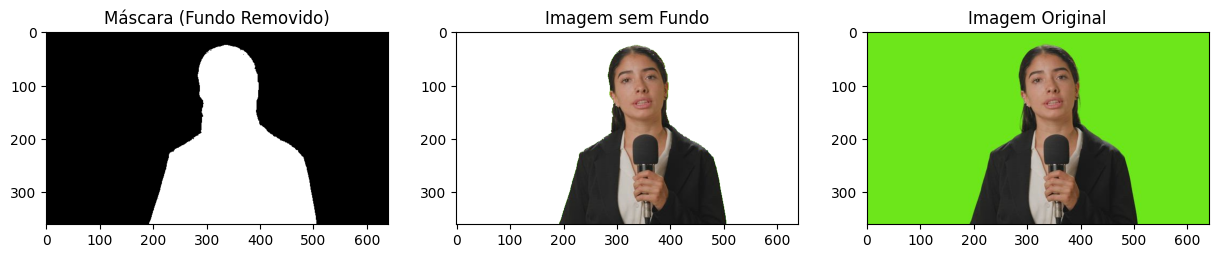

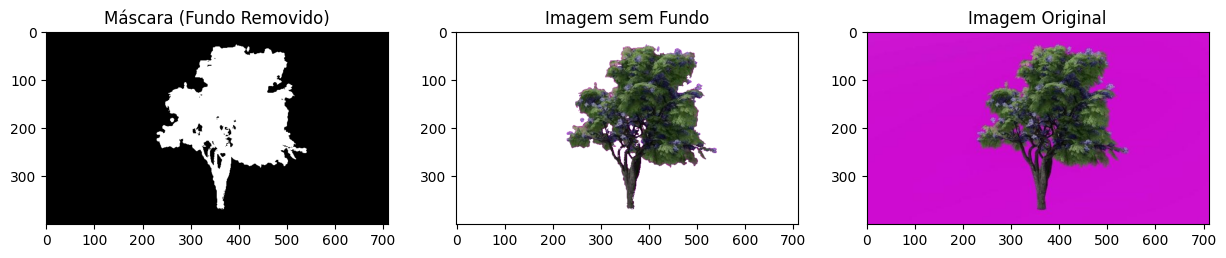

In [81]:
# Aplica a função desenvolvida para cada imagem
for img in imgs:
    # Obtém a máscara e a imagem sem o fundo
    mask, bgless_img = hls_bg_removal2000_8b(cv2.cvtColor(img,cv2.COLOR_RGB2HLS),5)
    
    plt.figure(figsize=(15,5))
    
    # Primeira subplot: exibe a máscara em escala de cinza
    plt.subplot(1, 3, 1)
    plt.imshow(mask, cmap="gray")
    plt.title("Máscara (Fundo Removido)")
    
    # Segunda subplot: exibe a imagem com fundo removido
    plt.subplot(1, 3, 2)
    plt.imshow(bgless_img)
    plt.title("Imagem sem Fundo")
    
    # Terceira subplot: exibe a imagem original
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.title("Imagem Original")
    
    plt.show()